**Домашнее задание** - Фильтрация картинок при помощи pytorch torch.nn.Conv2d

Прочитайте внимательно статью про то, что такое свёртка:

https://programforyou.ru/poleznoe/convolutional-network-from-scratch-part-zero-introduction

In [3]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

Пусть задана цветная картинка с изображением бабочки:

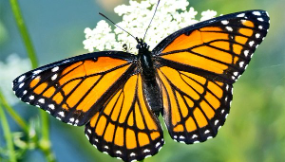

In [4]:
filename = 'image.png'
image = Image.open(filename)
image = image.convert('RGB')
image

Цель задания в том, чтобы реализовать функцию, которая бы по заданным входному изображению и матрицей размера 3x3, получала бы фильтрованное изображение, как на рисунке ниже:

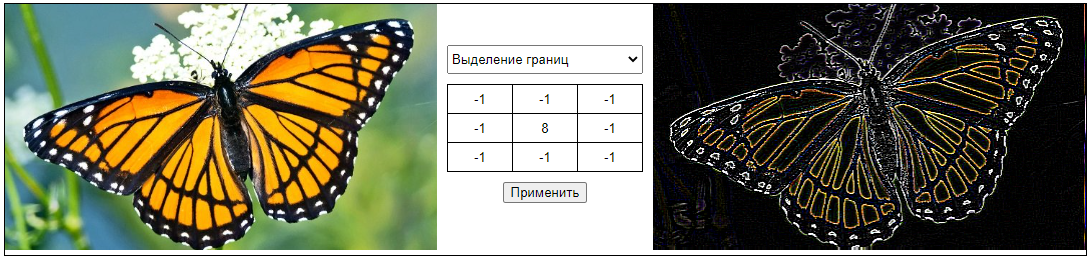

In [5]:
filename = 'laplace filter.png'
filter_example = Image.open(filename)
filter_example = filter_example.convert('RGB')
filter_example

Для реализации фильтра необходимо использовать свёртку, которая осуществляется модулем 'torch.nn.Conv2d'. В созданном объекте необходимо заменить имеющиеся веса на заданные веса фильтра, как в примере ниже:

In [6]:
conv_model = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, 
                       padding=2, stride=1, bias=False) # - конволюционный слой
print('Исходные случайные веса в слое:')
print(conv_model.weight)

Исходные случайные веса в слое:
Parameter containing:
tensor([[[[-0.0642,  0.0084,  0.0769],
          [-0.0439,  0.0915, -0.1156],
          [ 0.0742, -0.1218, -0.1503]],

         [[ 0.0146,  0.1677,  0.1105],
          [ 0.0541, -0.1301, -0.0080],
          [-0.1244,  0.1063, -0.1047]],

         [[ 0.1222,  0.0746,  0.1051],
          [ 0.0714,  0.1008, -0.1661],
          [-0.1401, -0.0666, -0.0466]]]], requires_grad=True)


In [7]:
W = torch.tensor([[[0.,0,0],[0,1,0],[0,0,0]], 
                  [[0.,0,0],[0,0,0],[0,0,0]],
                  [[0.,0,0],[0,0,0],[0,0,0]]])

with torch.no_grad():
    conv_model.weight.copy_(W)

print('Новые веса в слое:')
print(conv_model.weight)

Новые веса в слое:
Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], requires_grad=True)


In [8]:
import numpy as np
np.array(image).shape

(162, 285, 3)

Также необходимо научиться использовать стандартные трансформации из модуля 'torchvision.transforms' для того, чтобы преобразовывать картинку из формата, возвращаемого библиотекой 'PIL.Image' в 'torch.Tensor':
- transforms.ToTensor()
- transforms.ToPILImage()

In [9]:
t1 = transforms.ToTensor() # тут все меняется: размер был (162, 285, 3), стал (3, 162, 285),
                            # значения в картинке становится от 0 до 1.
tensor_image = t1(image)
tensor_image.shape

torch.Size([3, 162, 285])

In [10]:
# добавляет доп размерность (нулевую) для батчей (1 значит 1 картинка)
tensor_image = tensor_image.unsqueeze(dim=0)
tensor_image.shape

torch.Size([1, 3, 162, 285])

In [11]:
result = conv_model(tensor_image)
#result

In [12]:
result.shape

torch.Size([1, 1, 164, 287])

In [13]:
result = result.squeeze(dim=0)
# если значения в картинке больше 1, делаем их 1; если меньше 0, делаем их 0
result[result < 0] = 0
result[result > 1] = 1
result.shape

torch.Size([1, 164, 287])

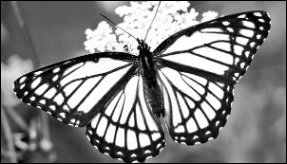

In [14]:
t2 = transforms.ToPILImage()
new_image = t2(result)
new_image

В данном примере преобразования привели к чёрно-белой одно-канальной картинке. Ваша же задача состоит в том, чтобы картинка после применения фильтра оставалась цветной трёх-канальной, а фильтр применялся к каждому из каналов по-отдельности.

Более того, результат применения фильтров должен совпадать с теми, что показаны в статье (ссылка на статью в самом вверху).

### Засунем теперь это все в функцию:

In [15]:
def filters(image, W):
    
    conv_model = nn.Conv2d(in_channels=3, # сколько входных фильтров
                       out_channels=3, # сколько фильтров хотим на выходе
                       groups=3, 
                       # если groups=in_channels, то к каждому входному слою применяется свой набор ядер 
                       # количеством out_channels / in_channels. То есть в данном случае к каждому входному 
                       # фильтру применится по одному ядру.
                       kernel_size=3, # размер ядра свертки
                       padding=1, # шаг, с которым передвигается ядро свертки
                       stride=1, # добавляем рамочку из нулей, чтобы выходная картинка не изменилась размером
                       bias=False) # смещение (которое +b)
    
    # Копируем вес
    with torch.no_grad():
        conv_model.weight.copy_(W)
        
    # преобразование из PIL.Image в torch.Tensor
    t1 = transforms.ToTensor()  
    tensor_image = t1(image) # тут все меняется: размер был (162, 285, 3), стал (3, 162, 285),
                             # значения в картинке становится от 0 до 1.
    
    tensor_image = tensor_image.unsqueeze(dim=0) # добавляет доп размерность (нулевую) для батчей (1 значит 1 картинка)
    result = conv_model(tensor_image)
    
    # обратное преобразование из torch.Tensor в PIL.Image
    result = result.squeeze(dim =0)
    # если значения в картинке больше 1, делаем их 1; если меньше 0, делаем их 0
    result[result < 0] = 0
    result[result > 1] = 1
    t2 = transforms.ToPILImage()
    new_image = t2(result)
        
    return new_image

### Используем разные весы 

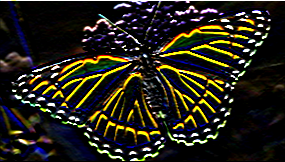

In [16]:
# Выделение границ по Х:
W1 = torch.tensor([[[[-1.,-2,-1],[0,0,0],[1,2,1]]], 
                  [[[-1.,-2,-1],[0,0,0],[1,2,1]]],
                  [[[-1.,-2,-1],[0,0,0],[1,2,1]]]])
f1 = filters(image, W1)
f1

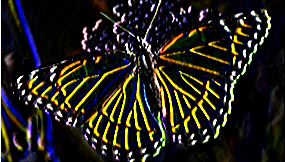

In [17]:
# Выделение границ по Y:
W2 = torch.tensor([[[[-1.,0,1],[-2,0,2],[-1,0,1]]], 
                  [[[-1.,0,1],[-2,0,2],[-1,0,1]]],
                  [[[-1.,0,1],[-2,0,2],[-1,0,1]]]])
f2 = filters(image, W2)
f2

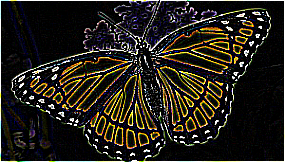

In [18]:
# Выделение границ 
W3 = torch.tensor([[[[-1.,-1,-1],[-1,8,-1],[-1,-1,-1]]], 
                  [[[-1.,-1,-1],[-1,8,-1],[-1,-1,-1]]],
                  [[[-1.,-1,-1],[-1,8,-1],[-1,-1,-1]]]])
f3 = filters(image, W3)
f3

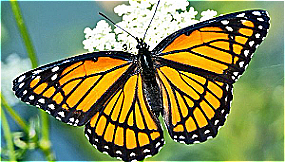

In [19]:
# Повышение резкости:
W4 = torch.tensor([[[[-1/6,-4/6,-1/6],[-4/6,26/6,-4/6],[-1/6,-4/6,-1/6]]], 
                  [[[-1/6,-4/6,-1/6],[-4/6,26/6,-4/6],[-1/6,-4/6,-1/6]]],
                  [[[-1/6,-4/6,-1/6],[-4/6,26/6,-4/6],[-1/6,-4/6,-1/6]]]])
f4 = filters(image, W4)
f4

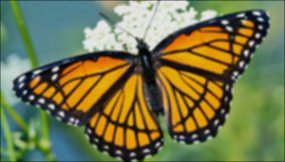

In [21]:
# Размытие:
W5 = torch.tensor([[[[0.1,0.1,0.1],[0.1,0.1,0.1],[0.1,0.1,0.1]]], 
                  [[[0.1,0.1,0.1],[0.1,0.1,0.1],[0.1,0.1,0.1]]],
                  [[[0.1,0.1,0.1],[0.1,0.1,0.1],[0.1,0.1,0.1]]]])
f5 = filters(image, W5)
f5

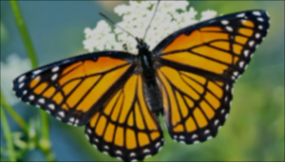

In [22]:
# Размытие Гаусса
W6 = torch.tensor([[[[0.05,0.1,0.05],[0.1,0.2,0.1],[0.05,0.1,0.05]]], 
                  [[[0.05,0.1,0.05],[0.1,0.2,0.1],[0.05,0.1,0.05]]],
                  [[[0.05,0.1,0.05],[0.1,0.2,0.1],[0.05,0.1,0.05]]]])
f6 = filters(image, W6)
f6